# **Fire Detection Model using VGG16 pre-trained model**
We analyzed the test images using the pre-trained model and tuning it to create more accurate data.

---



In [18]:
import torch
import cv2
import pandas as pd
import random
import shutil
import os                                   
import numpy as np                        
from PIL import Image                        
import matplotlib.pyplot as plt              

import warnings                              
warnings.filterwarnings('ignore')

from keras.applications import VGG16                         # pretrained CNN              
from keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 



---


After importing the required model and respective libraries, we created a helper function to copy files from source directory to the destination directory. It is using start and end indexes, and can be shuffled if needed. 

---



In [ ]:
def copy_file(src_path, dst_path, shuffle=False, no_modify=True, \
              start_index=None, end_index=None):
    src_files = os.listdir(src_path)
    
    # Shuffle files before copying 
    if shuffle==True:
        for _ in range(10):
            random.shuffle(src_files)
    
    os.chdir(dst_path) 
        
    for fname in src_files[start_index : end_index]:
        src = os.path.join(src_path, fname)
        img = Image.open(src)  
            
         # Convert all images in RGB mode 
        if img.mode != 'RGB':
            # PIL cannot convert P to RGB directly. 
            if img.mode == 'P':    
                img = img.convert('RGBA').convert('RGB')
            else: 
                img = img.convert('RGB')

        # Convert all images in .jpg format 
        if fname.endswith('.jpg'):
            dst = os.path.join(dst_path, fname)
            shutil.copyfile(src, dst)
        else:
            fn, fext = os.path.splitext(fname)
            img.save('{}.jpg'.format(fn))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#  !unzip /content/gdrive/MyDrive/train_images.zip



---

Connected to the Google Drive, and unzipped the train images into the working directory, reading the resulting ***csv*** file with corrrect formatting.

---



In [9]:
train_data = pd.read_csv('/content/gdrive/MyDrive/Datathon/train_labels.csv', header = None)

In [11]:
train_data.rename(columns={0: 'filename', 1: 'target'}, inplace = True)
train_data = train_data.astype({'filename': 'string'})
train_data = train_data.astype({'target': 'string'})

In [35]:
modelVGG = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(modelVGG)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

modelVGG.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4), 
             metrics=['acc'])



---


# About the model





In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________




---

Created two new directories for the respective datasets: train and validation. We have taken 3/4 of the train dataset to train and 1/4 for the validation with shuffling. 




In [29]:
base_dir = '/content/gdrive/MyDrive/Datathon'
train_val_imgs = '/content/gdrive/MyDrive/Datathon/train_imgs'
train_dir = os.path.join(base_dir, 'train_data')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

val_dir = os.path.join(base_dir, 'validation_data')
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

In [ ]:
# Three-quarter is for training and one-quarter is for validation 
n_23 = 3 * len(os.listdir(train_val_imgs)) // 4

copy_file(train_val_imgs, train_dir, end_index=n_23, shuffle=True)
copy_file(train_val_imgs, val_dir, start_index=n_23, shuffle=True)



---

# Data preparation

We performed data augmentation while starting the picture data generator. This artificially increased the amount of data available for training. For data augmentation, we utilized rotation, translation, shear, zooming, and horizontal flip.




In [36]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(    
                                                    train_data,
                                                    directory=train_dir,
                                                    x_col='filename',
                                                    y_col='target',
                                                    target_size=(150, 150), 
                                                    batch_size=32,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_dataframe(
                                                train_data,
                                                directory=val_dir,
                                                x_col='filename',
                                                y_col='target',
                                                target_size=(150, 150), 
                                                batch_size=32,
                                                class_mode='binary')

Found 1964 validated image filenames belonging to 2 classes.
Found 655 validated image filenames belonging to 2 classes.




---

**Training the model for 30 epochs.**




In [ ]:
history = model.fit(train_generator, epochs=30, 
                    validation_data=val_generator)



---

**Tuning the trained model and training for 50 additional epochs.**




In [ ]:
modelVGG.trainable = True
set_trainable = False
for layer in modelVGG.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
    
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator, epochs=50, 
                             validation_data=val_generator)



---

In [ ]:
# Saving the model
model.save('/content/gdrive/MyDrive/VGG16_finetuned.h5')

In [39]:
model = models.load_model('/content/gdrive/MyDrive/prev_models/VGG16_finetuned.h5')

In [ ]:
test_val_dir = '/content/test_imgs'
new_test_dir = os.path.join('/content', 'test/test')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)

copy_file(test_val_dir, new_test_dir, start_index=0)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        class_mode='binary', 
        batch_size=32)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator, nb_samples)

In [ ]:
prediction = np.round(predict).flatten()

In [ ]:
f_filenames = []
for word in filenames:
  word = word[5:]
  f_filenames.append(word)

In [ ]:
d = {'0': f_filenames, '1': prediction}
df = pd.DataFrame(data=d)
res = df.to_csv('/content/gdrive/MyDrive/test_labels.csv', header=False, index=False)



---


# Model performance analysis

In [ ]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

In [ ]:
def plot_func(entity):
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()



---


# Accuracy graph

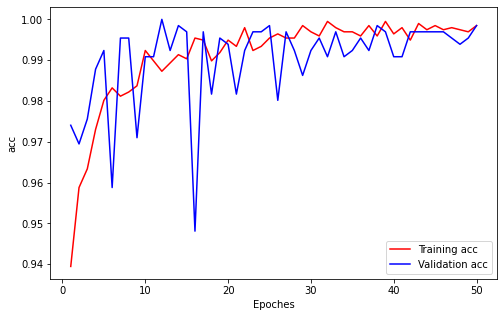

In [ ]:
plot_func('acc')



---

# Loss graph

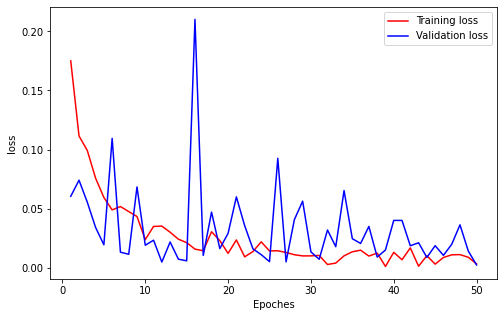

In [ ]:
plot_func('loss')



---


# Image analysis

In [41]:
# taking first batch from the generator 
img, label = val_generator[3] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

1/1 [==============================] - 6s 6s/step


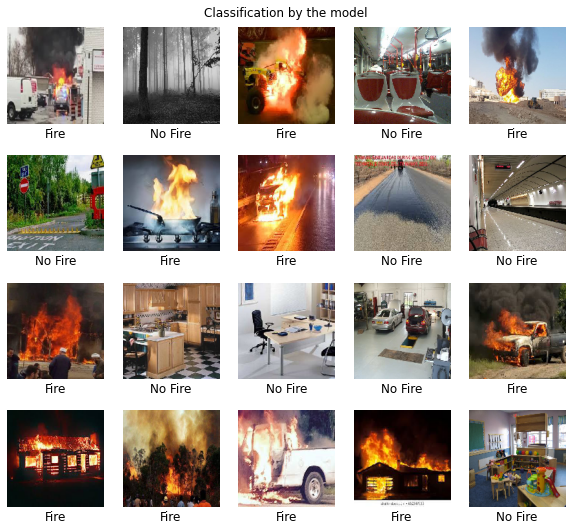

In [42]:
# Numeric to semantic labels 
label_dict = {1.0: 'Fire', 0.0: 'No Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

In [43]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all the batches 
for j in range(21):
    img, label = val_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 1:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

1/1 [==============================] - 3s 3s/step


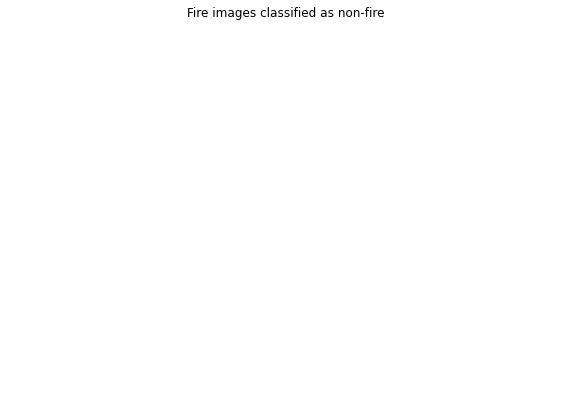

In [44]:
fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire):        
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

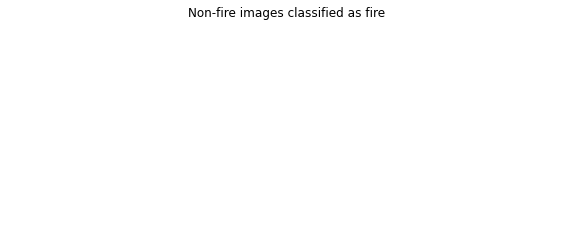

In [45]:
fig = plt.figure(figsize=(10, 4))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire):        
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')